In [20]:
import pandas as pd
import numpy as np
from pckgs.helper import timeseries_to_supervised, PnlCallback
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Ones
from tensorflow.keras.layers import Dense, LSTM, Reshape, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1, l2
import matplotlib.pyplot as plt
import seaborn as sb
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
price = pd.read_csv('../Price/datasets/bitcoin_position_day_20_thres1.csv', parse_dates=['Timestamp'])
price.rename(columns={'Timestamp':'date'}, inplace=True)
price.set_index('date', inplace=True)
y = price.loc[:,['down', 'same', 'up']]
y

,down,same,up
date,,,
2013-04-22,0,0,1
2013-04-23,0,0,1
2013-04-24,0,0,1
2013-04-25,1,0,0
2013-04-26,1,0,0
...,...,...,...
2019-12-27,0,1,0
2019-12-28,0,1,0
2019-12-29,0,0,1


In [28]:
lag = 21
df = pd.read_csv('./datasets/headline_sentiment_mean.csv', parse_dates=['date'], index_col=['date'])


df = timeseries_to_supervised(df, 'sentiment_score', lag=lag)
df.dropna(inplace=True)
df.drop('sentiment_score_t', axis=1, inplace=True)
x = df

x = x.reindex(y.index).ffill().bfill()
x

# lag = 21
# df = pd.read_csv('./datasets/headline_sentiment_counts.csv', parse_dates=['date'], index_col=['date'])
#
# df = timeseries_to_supervised(df, 'counts', lag=lag)
# df.dropna(inplace=True)
# df.drop('counts_t', axis=1, inplace=True)
# x = df
# x = x.reindex(y.index).ffill().bfill()
# x


,sentiment_score_t-1,sentiment_score_t-2,sentiment_score_t-3,sentiment_score_t-4,sentiment_score_t-5,sentiment_score_t-6,sentiment_score_t-7,sentiment_score_t-8,sentiment_score_t-9,sentiment_score_t-10,sentiment_score_t-11,sentiment_score_t-12,sentiment_score_t-13,sentiment_score_t-14,sentiment_score_t-15,sentiment_score_t-16,sentiment_score_t-17,sentiment_score_t-18,sentiment_score_t-19,sentiment_score_t-20
date,,,,,,,,,,,,,,,,,,,,
2013-04-22,0.024835,0.024835,0.024835,-0.068631,0.034087,0.544047,0.187794,-0.055822,-0.055822,0.066581,0.066581,0.066581,0.017407,0.017407,0.017407,0.017407,0.017407,-0.018071,-0.018071,-0.018071
2013-04-23,-0.003201,0.024835,0.024835,0.024835,-0.068631,0.034087,0.544047,0.187794,-0.055822,-0.055822,0.066581,0.066581,0.066581,0.017407,0.017407,0.017407,0.017407,0.017407,-0.018071,-0.018071
2013-04-24,0.142667,-0.003201,0.024835,0.024835,0.024835,-0.068631,0.034087,0.544047,0.187794,-0.055822,-0.055822,0.066581,0.066581,0.066581,0.017407,0.017407,0.017407,0.017407,0.017407,-0.018071
2013-04-25,-0.078547,0.142667,-0.003201,0.024835,0.024835,0.024835,-0.068631,0.034087,0.544047,0.187794,-0.055822,-0.055822,0.066581,0.066581,0.066581,0.017407,0.017407,0.017407,0.017407,0.017407
2013-04-26,0.122894,-0.078547,0.142667,-0.003201,0.024835,0.024835,0.024835,-0.068631,0.034087,0.544047,0.187794,-0.055822,-0.055822,0.066581,0.066581,0.066581,0.017407,0.017407,0.017407,0.017407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,-0.173105,-0.035868,-0.010401,-0.017671,-0.030418,0.044368,0.086441,-0.008117,-0.113960,-0.136853,-0.130920,-0.076284,-0.048364,-0.027700,-0.002369,-0.024807,-0.113208,-0.031633,0.058666,0.025085
2019-12-28,-0.084293,-0.173105,-0.035868,-0.010401,-0.017671,-0.030418,0.044368,0.086441,-0.008117,-0.113960,-0.136853,-0.130920,-0.076284,-0.048364,-0.027700,-0.002369,-0.024807,-0.113208,-0.031633,0.058666
2019-12-29,0.030249,-0.084293,-0.173105,-0.035868,-0.010401,-0.017671,-0.030418,0.044368,0.086441,-0.008117,-0.113960,-0.136853,-0.130920,-0.076284,-0.048364,-0.027700,-0.002369,-0.024807,-0.113208,-0.031633


In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
# x_train = x_train.values.reshape((x_train.shape[0], lag-1, int(x_train.shape[1] / (lag - 1))), order='F')
# print(x_train.shape)
# x_test = x_test.values.reshape((x_test.shape[0], lag-1, int(x_test.shape[1] / (lag - 1))), order='F')
# print(x_test.shape)

In [30]:
#create labeled y_test to measure pnl, confusion matrix
y_test_labeled = y_test.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_test_labeled = y_test_labeled.idxmax(axis=1)
# print(y_test_labeled)

# x_test_labeled = x_test.rename(columns={'down': -1, 'same': 0, 'up': 1})
# x_test_labeled = x_test_labeled.idxmax(axis=1)

In [31]:
df_candle = pd.read_csv('../Price/datasets/bitcoin_candle_day.csv', header=0, parse_dates=['Timestamp'])
df_candle.rename(columns={'Timestamp':'date'}, inplace=True)
df_candle.set_index('date', inplace=True)
df_candle.rename(columns={'Open': 'open', 'Low': 'low', 'High': 'high', 'Close': 'close'}, inplace=True)
# align dates
df_candle = df_candle.reindex(y_test.index)
# print(df_candle)

In [36]:
#does something for simple grouped mean(lil better that doc2vec)

model = Sequential()
model.add(Reshape((20, 1), input_shape=(20,)))
model.add(LSTM(16, activation='relu'))
# model.add(LSTM(32, activation='relu'))
# model.add(Dense(16, activation='relu', input_shape=(20,)))
# model.add(Dense(16, activation='relu', input_shape=(20,)))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy' , metrics=['accuracy'], optimizer=Adam(learning_rate=1e-3))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 20, 1)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 51        
Total params: 1,203
Trainable params: 1,203
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
# pnl = PnlCallback(x_test, df_candle, patience=20, name='headline_model')
mc = ModelCheckpoint('headline_model.h5',verbose=1, monitor='val_accuracy', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, verbose=1, patience=60)

history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test),
                    batch_size=64,
                    epochs=100, verbose=1, callbacks=[es,mc])#, shuffle=False)

model = load_model('headline_model.h5')

Epoch 1/100
30/31 [============================>.] - ETA: 0s - loss: 1.0971 - accuracy: 0.3464
Epoch 00001: val_accuracy improved from -inf to 0.32924, saving model to headline_model.h5
31/31 [==============================] - 1s 16ms/step - loss: 1.0970 - accuracy: 0.3466 - val_loss: 1.0959 - val_accuracy: 0.3292
Epoch 2/100
30/31 [============================>.] - ETA: 0s - loss: 1.0946 - accuracy: 0.3625
Epoch 00002: va

<AxesSubplot:>

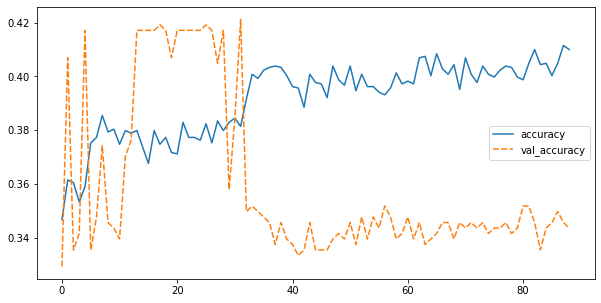

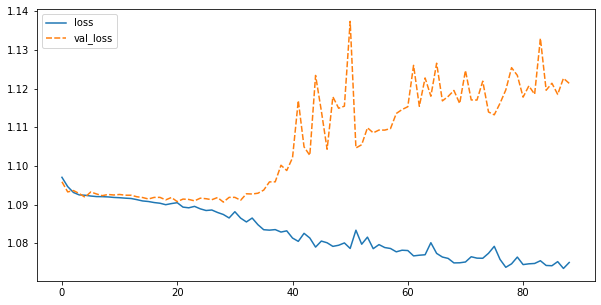

In [38]:
ac = {'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}
plt.figure(figsize=(10,5))
sb.lineplot(data=ac)

loss = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
plt.figure(figsize=(10,5))
sb.lineplot(data=loss)

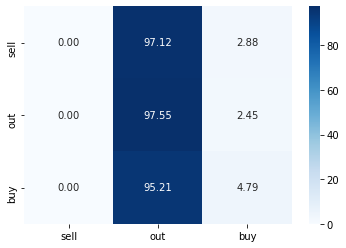

In [39]:
#create labeled y_pred for pnl, confusion matrix
y_pred = model.predict(x_test)
y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=y_test.index)
y_pred_labeled = y_pred_labeled.idxmax(axis=1)


from pckgs.evaluator import Evaluator
Evaluator.evaluate(y_pred_labeled, y_test_labeled, df_candle)


